# Introduction

We are going to simulate a $^{24}Mg$ atom trapped between 6 lasers and subject to a magnetic field.

# Doppler cooling for a 2 level system

For such a configuration and a 2 level system we would have the following forces:

The scattering force:
$$
\vec{F_{s}}=\hbar \vec{k} \Gamma \rho_{ee}
$$
with
$$\rho_{ee}=\frac{\Omega^{2}}{2\Omega^{2}+\Gamma^{2}+4\delta^{2}}$$

and 
$\delta = \delta_{L} - \vec{k}  \vec{v} + g_{j} m_{j}\mu_{B} \vec{\nabla}(B)  \vec{x}$

The dipole force:
$$
\vec{F_{dipole}}=\hbar  \nabla{\Omega} \frac{2 \delta \Omega}{2 \Omega^{2}+\Gamma^{2} + 4 \delta^{2} }
$$

The emission force:
$$
F_{emission}= \hbar k \Gamma \rho_{ee}
$$




If we stay close enough to resonance then we can neglect the dipole force. We will do so from now on.

On a cooling cycle the atom will absorb a photon and then spontaneously emit an other one in a random direction. Since the absorption of the photon is more likely to happen from the laser with opposite direction to the velocity of the atom, on average we are going to cool down the atom.


In order to simulate such process we can assume that our particles don't interact with each other. Therefore, we can simulate a big quantity of independent particles and then draw speed and position distributions after a given time.

In order to simulate one single particle we will discretize time. For each timestep:
* We can have a cycle event in which the particle will get excited by one of the 6 lasers (resulting in a kick in that direction) and then a photon will be emited in an isotropical random direction (resulting in an other kick). 

* The probability of such an event happening is determined by the decay rate and the timestep.

* The probability of each of the lasers hitting the atom is proportional to the excited state population in the steady state computed taking only that laser into account. In order to do so we need to consider the shape of the laser (assumed to be a gaussian transversally), and the doppler shift resulting from the velocity of the atom.

* Finally, independently of wheter we had a cooling cylce or not, the position is updated according to the velocity and the velocity is updated according to the gravitational acceleration.


Note that timesteps are independent between them and that we are only considering full cycles. On top of that, we are assuming that we are always in the steady state.

We are doing this approximation because the phasespace evolution is supposed to be very slow with respect to the timestep. Therefore we only need to consider processes on average.

# Effective 2-level system

For a 3 dimensional particle system, using the equipartition theorem and taking into account absorption and emission, we reach a minimal temperature of our system of:
$$
T_{min}=\frac{\hbar \Gamma}{6k_{B}}
$$

However, at the begining of the cooling process we want to have a high decay rate so that we can cool the particles before they escape the trap.

In order to increase the decay rate of our atom, we introduce a quenching laser $\Omega_{23}$ on top of the cooling laser $\Omega_{12}$. This laser will allow us to reach a higher energy state that has only one, very fast, decay path back to the ground state (i.e. $\Gamma_{2}<<\Gamma_{3},\Gamma_{4}$). As a result completing a whole cycle takes less time on average. The diagram looks something like so:

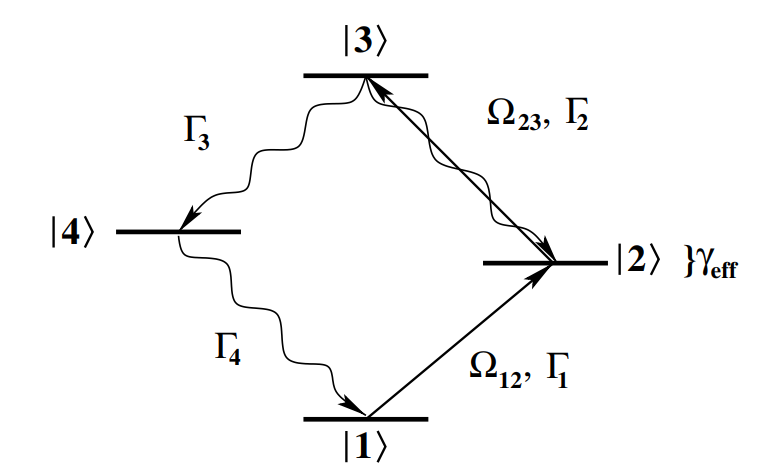


The effective decay rate is:
$$
\Gamma_{eff}=\Gamma_{1} + \frac{\Omega_{23}^{2}}{\Gamma_{3}}
$$

Which yields a scattering rate of:
$$
\Gamma_{scat}=\rho_{22}\Gamma_{eff}
$$



Now we need to slightly tweak the simulation process:
* Instead of having one photon absorption we are going to have 2. However, we can set the cooling and quenching lasers to have different polarities, thus increasing the probability of the two emissions being on the same direction.(For now we assume they will always be on the same direction).

* The 2 photon emission will be independent from each other.

* We are assuming that the inensity of the quenching beams is constant across the width of the cooling laser.


Based on the paper [insert paper] the double recoil affects the results substantially and is thus important to simulate.

# Implementation

Since our probabilities will be proportional to the excited state population let's break it down.

$$\rho_{ee}=\frac{\Omega_{12}^{2}}{2\Omega_{12}^{2}+\Gamma_{eff}^{2}+4\delta^{2}}$$

and remember $\delta = \delta_{L} - \vec{k}  \vec{v} + \frac{g_{j} m_{j}\mu_{B}}{\hbar} \vec{\nabla}(B)  \vec{x}$



$$
\Omega_{12}^{2}=\Omega_{0}^{2}exp(-\frac{r_{e_{i}}^{2}}{w^2})
$$

Where $r_{e_{i}}$ is the perpendicular component of the position in the direction $e_{i}$ and w is the waist of our laser.

Note that since we are considering $m_{j}=\pm 1$ we need to consider in total 12 possilities.

### The orders of magnitude are the following:
* $\Omega_{0}\approx 10^5 - 10^6 [Hz]$
* $\Gamma_{eff}\approx 10^4 [Hz]$
* $k\approx 10^7 [m^{-1}]$
* $\mu_{B} \approx 10^{-23} [J T^{-1}]$
* $ \mid \nabla B \mid = 0.05 [T] $
* $\hbar \approx 10^{-34}$
* $\mid v \mid \approx 10^{-1}-10^{0}$
* $\mid x \mid \approx 10^{-3}$


Remember $1$ Tesla is $10^{4}$ Gauss


### Therefore:
* $\vec{k}  \vec{v}  \approx 10^{7}$
* $\frac{\mu_{B}}{\hbar}=8.8 e10$

In the code we are going to add $8.8e6$ in order to imput the gradient of mag field in G per m


# TODO
* take into account polarization

* take into acount linewidth? Are we already doing so by taking into account the shape of the laser?

* should we give more tolerance to the particles that leave the box maybe 2w or more


## Coding

We import our functions.

In [177]:
from November27 import *
from Plots import *
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we initialize a MonteCarlo class that will contain all the data and the methods required in order to make the simulation. Note that one of them is an "atom" which a simple dataclass storing the parameters of the atomic structure of a given atom.

Finally, we have a optimizer class that will allow us to find the optimal parameters for our experiment.The optimizer starts by running a simulation with constant detuning for the laser.

In [175]:
N=int(1e4)
ts=int(1e3+1)
monty=MonteCarlo(atom=Magnesium,
                 N=N,
                 timesteps=ts,
                 deltaL=None,
                 sigmar=5e-4,
                 sigmav=1.5,
                 dt=20e-6,
                 Omega12=5e5,
                 Magnetic_gradient=np.array([5,5,2.5]),
                 waist= 2e-3)


np.linalg.norm(monty.V,axis=1).mean()
optimizer=Optimizer(monty)


Here we can see the results of the first simulation.
On the first plot, we have the average distance from the origin of the particles as well their range from 10th to 90th percentile. We also plot, in red, the ammount of particles leaving per second (smoothed by a moving average).


One the second plot,he laser detuning has been divided by the wave number in order to have the same units.

In [178]:
plots(monty,w=10,t=-1)
plot_temperature(monty,lq=0.1,hq=0.9)

The final average Velocity is:0.43 m/s
The final average Distance from the Origin is:1.289 mm
In the end we still have 11.9% of the particles


In [179]:
print(monty.temperature_measure)
figHT = TimeHist(monty_plot=monty,observable='V',measure=monty.temperature_measure,xtitle='Temperature[mK]',nbins=15,t=-1)
figHT.show()

[('module', None), ('temperature', None), ('multiply', 1000)]


In [180]:
module_measure=[('module',None)]
figHV = TimeHist(monty_plot=monty,observable='V',measure=module_measure,xtitle='Velocity',nbins=15)
figHV.show()

In [181]:
fig=TimeBox(monty,'V',sampleN=1000,sampleT=20,t=-1)
#fig=TimeCoords(monty,observable='V')
#fig=PhaseSpace(monty_plot=monty,sampleN=1000,sampleT=50,t=0)

Now we might want to establish a relation between the temperature, the initial deviation for the velocity and the average velocity itself.
Note the following relations:

$$
<V^{2}>=<V_{x}^{2}>+<V_{y}^{2}>+<V_{z}^{2}>
$$
Since the velocities are independent and they follow a normal distribution with the same variance we can write:
$$
<V^{2}>=3<V_{x}^{2}>=3\sigma^{2}
$$

On the other hand, assuming an ideal gaz:
$$
\frac{1}{2}m_{atom}<V^{2}>=\frac{3}{2}k_{B}T
$$

Therefore we have that:
$$ T=\frac{m_{atom}}{k_{B}} \sigma^{2} $$

In [182]:
kb=1.38e-23
def temp_to_std(monty,T):
    m=monty.atom.m
    return np.sqrt(kb/m *T)
    
def std_to_temp(monty,std):
    return m/kb * std**2

print('A temperature of 2mk corresponds to a sigmav=',temp_to_std(monty,2e-3))


A temperature of 2mk corresponds to a sigmav= 0.826955293185504


Here we want to do 2 particular plots. Loading efficiency in function of Temperature, and 

In [183]:
Magnesium=Atom(sct=2e4,lmbds=[457e-9,462e-9,634e-9,285e-9],m_uma=24.305)
N,ts=1000,501

sigmas=np.linspace(0.8,1.5,num=7)
percentiles=np.linspace(0.5,0.8,num=4)

monty=MonteCarlo(atom=Magnesium,N=N,timesteps=ts,sigmav=1,Magnetic_gradient=np.array([5,5,2.5]))
optimizer = Optimizer(monty) 

optimizer.exhaustive_tries(percentiles, sigmas)

eff_vs_sigmas = optimizer.results[:,:,0].max(axis=1)




0.8 0.5
0.8 0.6
0.8 0.7000000000000001
0.8 0.8
0.9166666666666667 0.5
0.9166666666666667 0.6
0.9166666666666667 0.7000000000000001
0.9166666666666667 0.8
1.0333333333333334 0.5
1.0333333333333334 0.6
1.0333333333333334 0.7000000000000001
1.0333333333333334 0.8
1.15 0.5
1.15 0.6
1.15 0.7000000000000001
1.15 0.8
1.2666666666666666 0.5
1.2666666666666666 0.6
1.2666666666666666 0.7000000000000001
1.2666666666666666 0.8
1.3833333333333333 0.5
1.3833333333333333 0.6
1.3833333333333333 0.7000000000000001
1.3833333333333333 0.8
1.5 0.5
1.5 0.6
1.5 0.7000000000000001
1.5 0.8


In [144]:
fig=px.line(optimizer.efficiency)
fig.show()